# Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import gensim
import gensim.downloader
from torchtext.legacy import data, datasets
from torch.utils.data import DataLoader, Dataset
import random
import sklearn.metrics
import spacy
from pdb import set_trace as st
from matplotlib import pyplot as plt

device = 'cuda'

SEED = 1234
MAX_VOCAB_SIZE = 25_000
BATCH_SIZE = 64

/home/liaowenbin/programfiles/anaconda3/envs/dl_a5/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = np.float)

from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

print(vars(train_data.examples[0]))

import random

SEED = 1234

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE)

# print batch information
batch = next(iter(train_iterator)) # for batch in train_iter
print(batch.text.numpy()) # input sequence
print(batch.label.numpy()) # groud truth

Number of training examples: 25000
Number of testing examples: 25000
{'text': ['Tremendous', 'black', '--', 'and', '-', 'white', 'nighttime', 'cinematography', ',', 'and', 'plenty', 'of', 'it', ',', 'highlights', 'this', 'supposedly', '-', 'true', 'life', 'account', 'of', 'a', '1950s', 'murder', 'in', 'Kansas', 'in', 'which', 'an', 'entire', 'family', 'was', 'wiped', 'out', 'by', 'two', 'men.<br', '/><br', '/>The', 'story', 'was', 'written', 'by', 'Truman', 'Capote', ',', 'so', 'you', 'get', 'the', 'very', 'Liberal', 'anti', '-', 'death', 'penalty', 'message', 'at', 'the', 'end', 'of', 'the', 'film', ',', 'which', 'is', 'ludicrous', 'knowing', 'the', 'facts', 'of', 'this', 'case', '.', 'Robert', 'Blake', 'and', 'Scott', 'Wilson', 'play', 'the', 'two', 'atheist', 'losers', 'who', 'have', 'twisted', 'outlooks', 'on', 'life', 'and', 'who', 'unnecessarily', 'murder', 'this', 'nice', 'family', '.', '<', 'br', '/><br', '/>Despite', 'the', 'annoying', 'slant', 'at', 'the', 'end', ',', 'this',

In [3]:
vec_model = gensim.downloader.load('glove-wiki-gigaword-300')
each_word_shape = vec_model['hello'].shape
each_word_shape

(300,)

In [4]:
# convert text to tensor for each batch.
def batch_text_to_tensor(text):
    return torch.tensor(np.stack([np.stack([ # this list converts the string words across all batches into dense representations
        vec_model[tok]
        if tok in vec_model.key_to_index.keys()
        else torch.zeros(each_word_shape)
        for tok in toks]) 
                                  for toks in [ # this list converts all indices to string words, for all batches
                                      [ # this list converts all indices to string words
                                          TEXT.vocab.itos[idx]
                                          for idx 
                                          in batch.text.numpy()[:,i]] 
                                      for i 
                                      in range(BATCH_SIZE)]]))

batch_text_to_tensor(batch.text).shape

torch.Size([64, 1039, 300])

# Model Definition

In [5]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=1, batch_first=True)
        self.act = nn.ReLU()
        self.linear = nn.Linear(256, 2)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.act(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x[:,-1,:]


In [6]:
model = LSTM()
model(batch_text_to_tensor(batch.text)).shape

torch.Size([64, 2])

# Experiments

Epoch 0, trainloss 0.6908023703272326, valloss 0.686808341135413, valacc 0.5023834745762712
Epoch 1, trainloss 0.690394676949856, valloss 0.6851891562090082, valacc 0.5229078389830508
Epoch 2, trainloss 0.6900490785602236, valloss 0.6817885844384209, valacc 0.5256885593220338
Epoch 3, trainloss 0.6896724798818574, valloss 0.6754285930576971, valacc 0.5532309322033898
Epoch 4, trainloss 0.6921414256530957, valloss 0.6874391815419925, valacc 0.490333686440678
Testacc 0.5531090153452686


Text(0, 0.5, 'Accuracy')

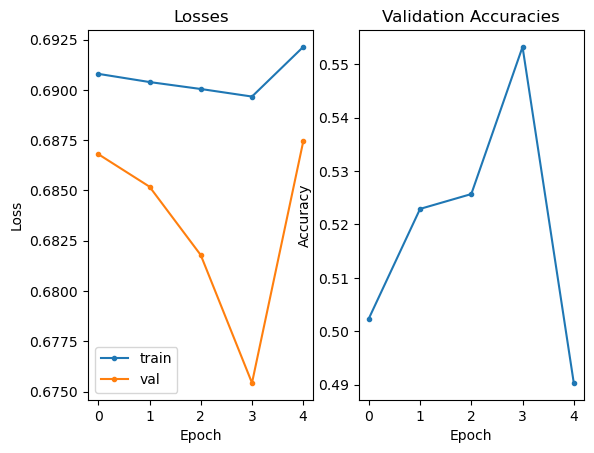

In [7]:
model = LSTM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accs = []

for epoch in range(5):
    epoch_train_loss = 0
    epoch_val_loss = 0
    acc = 0
    for batch in train_iterator:
        if len(batch.label) < BATCH_SIZE:
            continue # drop_last
            
        opt.zero_grad()

        y = torch.LongTensor(batch.label.numpy()).to(device)
        x = batch_text_to_tensor(batch.text).to(device)
        xhat = model(x)

        loss = criterion(xhat, y)

        loss.backward()
        opt.step()

        epoch_train_loss += float(loss.item())

    with torch.no_grad():
        for batch in valid_iterator:
            if len(batch.label) < BATCH_SIZE:
                continue

            y = torch.LongTensor(batch.label.numpy()).to(device)
            x = batch_text_to_tensor(batch.text).to(device)
            xhat = model(x)

            loss = criterion(xhat, y)

            epoch_val_loss += float(loss.item())

            acc += sklearn.metrics.accuracy_score(
                np.argmax(xhat.detach().cpu().numpy(),1),  
                y.detach().cpu().numpy())

    epoch_train_loss /= len(train_iterator)
    epoch_val_loss /= len(valid_iterator)
    acc /= len(valid_iterator)

    print(f'Epoch {epoch}, trainloss {epoch_train_loss}, valloss {epoch_val_loss}, valacc {acc}')
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_accs.append(acc)
    
acc = 0
with torch.no_grad():
    for batch in test_iterator:
        if len(batch.label) < BATCH_SIZE:
            continue
        y = torch.LongTensor(batch.label.numpy()).to(device)
        x = batch_text_to_tensor(batch.text).to(device)
        xhat = model(x)

        acc += sklearn.metrics.accuracy_score(
            np.argmax(xhat.detach().cpu().numpy(),1),
            y.detach().cpu().numpy())

acc /= len(test_iterator)
print(f'Testacc {acc}')

plt.subplot(1,2,1)
plt.title('Losses')
plt.plot(train_losses, marker='.', label='train')
plt.plot(val_losses, marker='.', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.title('Validation Accuracies')
plt.plot(val_accs, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


Epoch 0, trainloss 0.6907435390200928, valloss 0.6867998201968306, valacc 0.5211864406779662
Epoch 1, trainloss 0.6904763779500975, valloss 0.6826407247680729, valacc 0.5360169491525424
Epoch 2, trainloss 0.6901721312616863, valloss 0.6832325478731576, valacc 0.527145127118644
Epoch 3, trainloss 0.6897531097387746, valloss 0.6758307162987984, valacc 0.550052966101695
Epoch 4, trainloss 0.6895092975919264, valloss 0.680011399216571, valacc 0.5419756355932204
Epoch 5, trainloss 0.6891113265152395, valloss 0.6866383097939572, valacc 0.5346927966101694
Epoch 6, trainloss 0.6888948185165433, valloss 0.6709297243821419, valacc 0.5576006355932204
Epoch 7, trainloss 0.6879427396032932, valloss 0.6812698856248693, valacc 0.5508474576271186
Epoch 8, trainloss 0.688052710390439, valloss 0.6901412040500318, valacc 0.5411811440677966
Epoch 9, trainloss 0.6881647405833223, valloss 0.6666824155944889, valacc 0.5761387711864406
Testacc 0.6076166879795396


Text(0, 0.5, 'Accuracy')

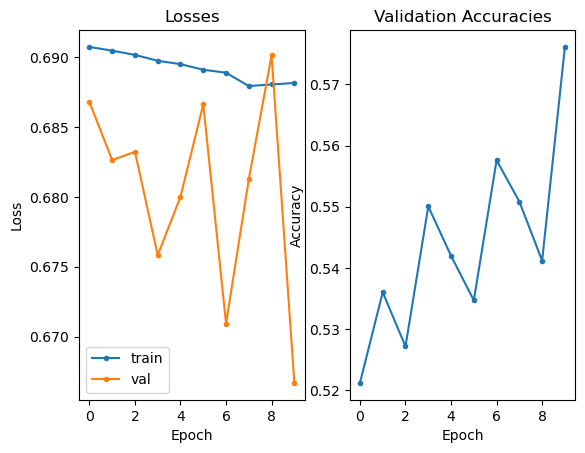

In [8]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=1, batch_first=True)
        self.act = nn.ReLU()
        self.linear = nn.Linear(256, 128)
        self.act2 = nn.ReLU()
        self.linear2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.act(x)
        x = self.linear(x)
        x = self.act2(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x[:,-1,:]

model = LSTM().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accs = []

for epoch in range(10):
    epoch_train_loss = 0
    epoch_val_loss = 0
    acc = 0
    for batch in train_iterator:
        if len(batch.label) < BATCH_SIZE:
            continue # drop_last
            
        opt.zero_grad()

        y = torch.LongTensor(batch.label.numpy()).to(device)
        x = batch_text_to_tensor(batch.text).to(device)
        xhat = model(x)

        loss = criterion(xhat, y)

        loss.backward()
        opt.step()

        epoch_train_loss += float(loss.item())

    with torch.no_grad():
        for batch in valid_iterator:
            if len(batch.label) < BATCH_SIZE:
                continue

            y = torch.LongTensor(batch.label.numpy()).to(device)
            x = batch_text_to_tensor(batch.text).to(device)
            xhat = model(x)

            loss = criterion(xhat, y)

            epoch_val_loss += float(loss.item())

            acc += sklearn.metrics.accuracy_score(
                np.argmax(xhat.detach().cpu().numpy(),1),  
                y.detach().cpu().numpy())

    epoch_train_loss /= len(train_iterator)
    epoch_val_loss /= len(valid_iterator)
    acc /= len(valid_iterator)

    print(f'Epoch {epoch}, trainloss {epoch_train_loss}, valloss {epoch_val_loss}, valacc {acc}')
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_accs.append(acc)
    
acc = 0
with torch.no_grad():
    for batch in test_iterator:
        if len(batch.label) < BATCH_SIZE:
            continue
        y = torch.LongTensor(batch.label.numpy()).to(device)
        x = batch_text_to_tensor(batch.text).to(device)
        xhat = model(x)

        acc += sklearn.metrics.accuracy_score(
            np.argmax(xhat.detach().cpu().numpy(),1),
            y.detach().cpu().numpy())

acc /= len(test_iterator)
print(f'Testacc {acc}')

plt.subplot(1,2,1)
plt.title('Losses')
plt.plot(train_losses, marker='.', label='train')
plt.plot(val_losses, marker='.', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.title('Validation Accuracies')
plt.plot(val_accs, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


# Report

## Embeddings

We use word embeddings to allow for dense representations of inputs, which are easier for the model to learn since they encode more information and require fewer parameters. To save time, we decided to make use of pre-trained word embeddings instead of training new embeddings from scratch on the dataset. 

The initial plan was to use spaCy's word embeddings as spaCy was already installed, and spaCy word embeddings exist for any word, even words that are outside the spaCy model's vocabulary. However the spaCy embeddings turned out to be too slow to generate. Hence instead we decided to use gensim's `glove-wiki-gigaword-300` pretrained embedding model. As the name suggests, this model embeds every word as a vector of length 300. The reason for choosing this pretrained embedding model, as opposed to another pretrained embedding model, is because the model was trained on a corpus of wiki articles. This is good because wiki articles and movie reviews are both meant to be informative, so they are very likely to have similar vocabularies and similar latent word distributions. This is better than other models like `glove-twitter-50`, which was trained on Twitter tweets which have a very different vocabulary from movie reviews.

Using the word embedding model, we are able to convert every input into a sequence of vectors of length 300. Note that the correspondence is not one-to-one, since there may be some words in the IMDB vocabulary which are not in the wiki vocabulary. For such words, since an embedding does not exist, we add a zero-vector instead of an embedding.

## Choice of RNN, Optimizer, Loss

For the RNN, we decided to use the LSTM as opposed to a more traditional RNN architecture. This is because the LSTM has additional parameters which allow it to determine what knowledge should be remembered and what knowledge should be forgotten. These parameters allow it to learn long-term dependencies much better than the usual traditional RNNs; this is very useful since some of the reviews have thousands of words.

For the optimizer, we used the Adam optimizer as it is generally more robust and adaptable than SGD. Previous assignments' results also showed Adam optimizer to perform better.

For the loss function, we used the cross entropy loss. This is because the given task is a binary classification task with two classes (positive and negative). As such, we use a softmax activation. The cross entropy loss is the natural loss function to use under such circumstances.


## First Attempt

The first attempt trained for 5 epochs with a learning rate of 0.001. The model architecture was as follows:

* LSTM with input size of 300 and output size of 256
* ReLU activation
* Fully-connected layer with input size of 256 and output size of 2
* Softmax activation

This gave a test accuracy of 0.553. However we also noticed the validation accuracies followed a very strange pattern, as the final epoch had a validation accuracy of 0.490. Hence we decided to try again. It was possible that the model parameters were missing the local minima, which might have implied a learning rate that was too large. Hence we reduced the learning rate and increased the number of epochs to compensate. We also increased the model complexity.

Graphs of loss and validation accuracy are shown in the above section.

## Second Attempt

The second attempt trained for 10 epochs with a learning rate of 0.0003. The model architecture was as follows:


* LSTM with input size of 300 and output size of 256
* ReLU activation
* Fully-connected layer with input size of 256 and output size of 128
* ReLU activation
* Fully-connected layer with input size of 128 and output size of 2
* Softmax activation

This time the validation accuracy of the final epoch was 0.576. Every epoch also had a validation accuracy above 0.500, which was a good sign. The model's final test accuracy was 0.608. This test accuracy is very good considering that it is much better than the "expected" accuracy of 0.550.

Graphs of loss and validation accuracy are shown in the above section.

A figure of the architecture is provided with this notebook. 